In [27]:
import sys

print("Python version")
print(sys.version)

Python version
3.9.17 (main, Jul  5 2023, 20:47:11) [MSC v.1916 64 bit (AMD64)]


In [28]:
import tensorflow as tf

devices = tf.config.experimental.list_physical_devices('GPU')
if devices:
    print("GPU available")
else:
    print("No GPU found")

GPU available


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
warnings.filterwarnings("ignore")


In [4]:
import zipfile 
from zipfile import ZipFile

filepath = os.getcwd()
with zipfile.ZipFile('archive.zip','r') as zip_ref:
    zip_ref.extractall(filepath)

In [5]:
df = pd.read_csv(r'D:\vscode\Sentiment Analysis for Steam Reviews NLP\train.csv')
df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [6]:
df['Texts'] = df.iloc[:, 3]
df['Label'] = df.iloc[:, 4]
df = df[["Label","Texts"]]

In [7]:
df.head()

,Label,Texts
0,1,I'm scared and hearing creepy voices. So I'll...
1,1,"Best game, more better than Sam Pepper's YouTu..."
2,1,"A littly iffy on the controls, but once you kn..."
3,1,"Great game, fun and colorful and all that.A si..."
4,1,Not many games have the cute tag right next to...


In [8]:
df.drop_duplicates(subset='Texts', inplace=True)

In [11]:
df.duplicated(subset='Texts').sum()

0

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17490 entries, 0 to 17493
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   17490 non-null  int64 
 1   Texts   17490 non-null  object
dtypes: int64(1), object(1)
memory usage: 409.9+ KB


In [13]:
df.dropna(inplace=True)

[]

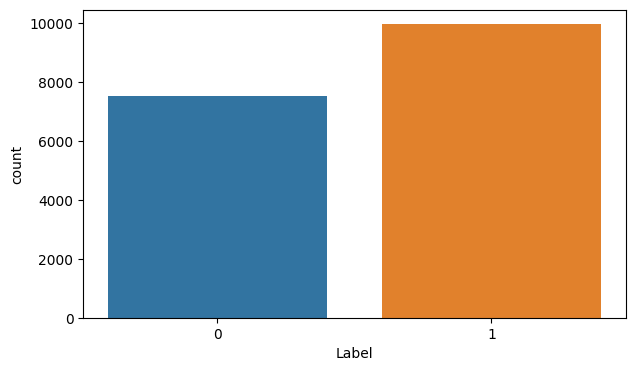

In [14]:
plt.figure(figsize=[7, 4])
sns.countplot(x= df["Label"], data=df)
plt.plot()

In [16]:
import re 
import string

def text_preprocessing(text):

    text = re.sub(r'[^a-zA-Z\s]', "", text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = text.replace('<unk>', 'UNKNOWN_TOKEN')

    arr = []
    for i in text:
        if i in string.punctuation:
            arr.append("")
        else:
            arr.append(i)
    return "".join(arr).lower()

In [17]:
df["Texts"] = df['Texts'].apply(text_preprocessing)

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
max_length = 2000
vocabs = 10000

def convert_to_number(text):
    tokenizer = Tokenizer(
      num_words=vocabs,
      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
      lower=True,
      split=' ',
      char_level=False,
      oov_token="<oov>",
      analyzer=None,
  )
    tokenizer.fit_on_texts(text)
    sequence = tokenizer.texts_to_sequences(text)
    pad_sequence = pad_sequences(sequence, padding="pre", maxlen=max_length)

    return pad_sequence

x = convert_to_number(df["Texts"])

In [20]:
from sklearn.model_selection import train_test_split
y = df["Label"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)

In [21]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Flatten, LSTM, Dropout, GRU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
callbacks = EarlyStopping(patience=2, monitor= 'val_loss')


In [23]:
model = Sequential([
    Embedding(input_dim = vocabs, output_dim = 100, input_length=max_length),
    LSTM(128, recurrent_activation="sigmoid"),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(1, activation = "sigmoid"),
])


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,133,889
Trainable params: 1,133,889
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=["accuracy"],
              )

model.fit(x_train, y_train,
          epochs=5,
          validation_data=(x_test, y_test),
          batch_size=32,
          callbacks = callbacks
          )